In [1]:
from collections import defaultdict
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



# import pandas as pd
# import glob
# import os
# import matplotlib.pyplot as plt
# import json
# import numpy as np
# from cycler import cycler
# from matplotlib.pyplot import cm

import sys; sys.path.append("models")
from config import get_case_config, get_case_sensitivities
import sensitivity, utils
from strategies import RETURN_KEYS

In [2]:
def read_json(fpath):
    with open(fpath, "r") as f:
        return json.loads(f.read())

In [3]:
data_dir = os.path.join(os.environ['DATA'], "tti-explorer", "pinch-points")
lockdowns = next(os.walk(data_dir))[1]

In [4]:
keys_to_plot = [RETURN_KEYS.reduced_r, RETURN_KEYS.tests]
rc_dct = {
    'figure.figsize': (14, 6),
    'figure.max_open_warning': 1000
}
output_folder = os.path.join(os.environ['REPOS'], 'tti-explorer', 'charts')

In [5]:
senstivity_results = defaultdict(lambda: defaultdict(list))
# tis will break with sensitivity

for lockdown in lockdowns:
    folder = os.path.join(data_dir, lockdown)
    for cfg_file in filter(lambda x: x.startswith("config") and x.endswith('.json'), os.listdir(folder)):
        i = int(cfg_file.replace("config_", '').replace(".json", ''))
        cfg = read_json(os.path.join(folder, cfg_file))
        target = cfg[sensitivity.TARGET_KEY]
        results = pd.read_csv(os.path.join(folder, f"run_{i}.csv"), index_col=0)
        senstivity_results[lockdown][target].append((cfg['config'][target], results))

In [6]:
# group by lockdown level and then again by parameter
lockdown_results = dict()
for i in range(1, 6):
    lockdown_results[f"L{i}"] = {k: v for k, v in senstivity_results.items() if int(k[1]) == i}
lockdown_results = {k: utils.swaplevel(v) for k,v in lockdown_results.items()}

In [7]:
def nice_lockdown_name(name):
    return " ".join(name.split("_")[1:]).title()

def take_key(res_list, key):
    return np.array([res[key].item() for res in res_list])

def nice_param_name(name):
    return name


def plot_sim_results(ax, sim_results, key, label):
    xvals, reslist = zip(*sim_results)
    arg_order = np.argsort(xvals)
    xaxis = np.array(xvals)[arg_order]
    res = take_key(reslist, key)[arg_order]
    ax.plot(xaxis, res, label=label)


def plot_lockdown(lockdown_dct, deck, keys_to_plot):
    for param_name, sim_results in lockdown_dct.items():
        
        fig, axarr = plt.subplots(1, len(keys_to_plot), sharex=True)
        for key, ax in zip(keys_to_plot, axarr.flat):
            for lockdown_name, res in sim_results.items():
                plot_sim_results(ax, res, key, nice_lockdown_name(lockdown_name))
            
            ax.set_ylabel(key)
            ax.set_xlabel(nice_param_name(target))
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        fig.legend(
            *ax.get_legend_handles_labels(),
            ncol=4,
            bbox_to_anchor=(0.45, -0.01),
            loc="lower center",
            fancybox=False,
        )
        fig.suptitle(nice_param_name(param_name), y=0.95)
        plt.subplots_adjust(wspace=0.05)
        
        deck.add_figure(fig)
    return fig


<ipython-input-7-6e958977a295>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axarr = plt.subplots(1, len(keys_to_plot), sharex=True)
<ipython-input-7-6e958977a295>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axarr = plt.subplots(1, len(keys_to_plot), sharex=True)
<ipython-input-7-6e958977a295>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

<ipython-input-7-6e958977a295>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axarr = plt.subplots(1, len(keys_to_plot), sharex=True)
<ipython-input-7-6e958977a295>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axarr = plt.subplots(1, len(keys_to_plot), sharex=True)
<ipython-input-7-6e958977a295>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

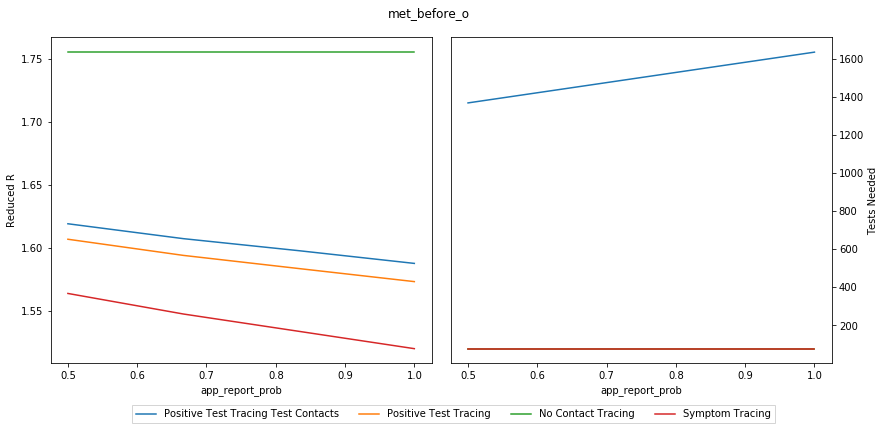

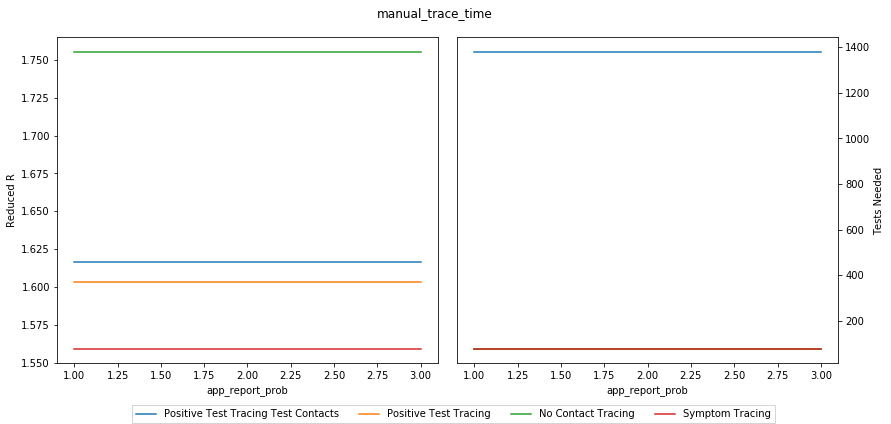

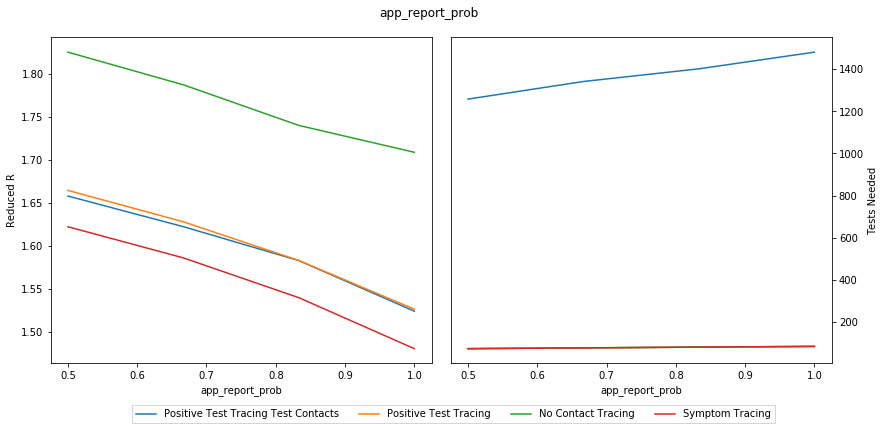

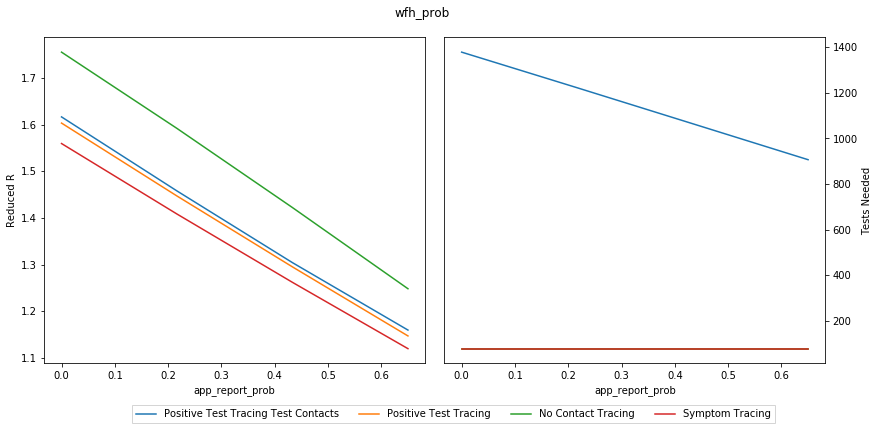

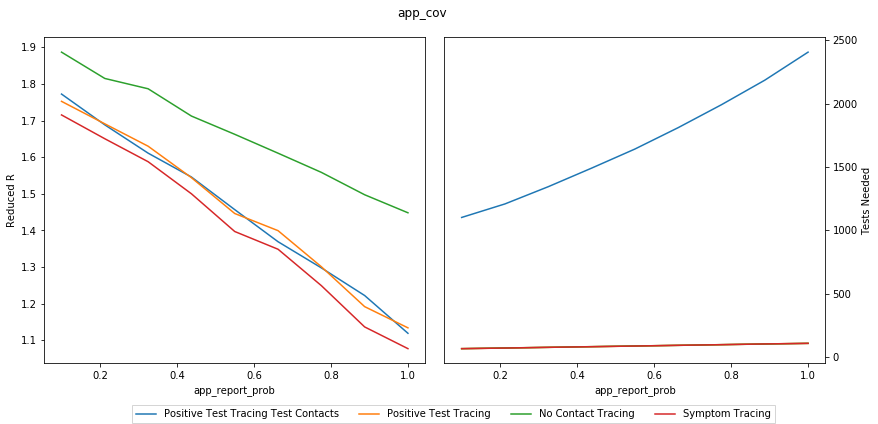

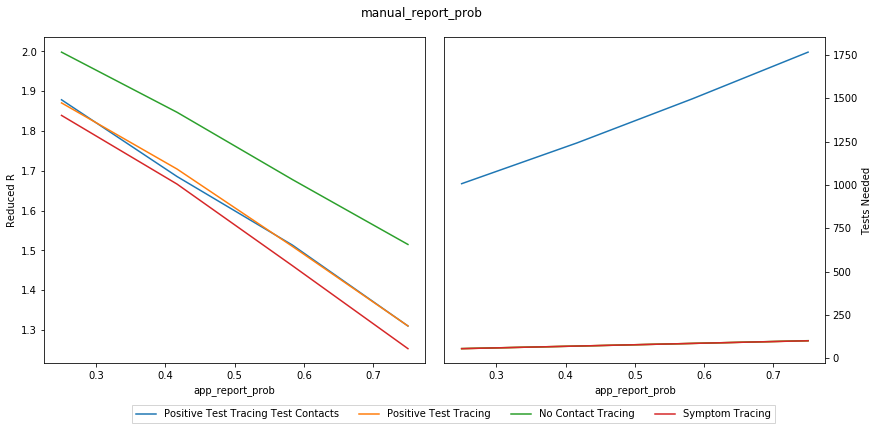

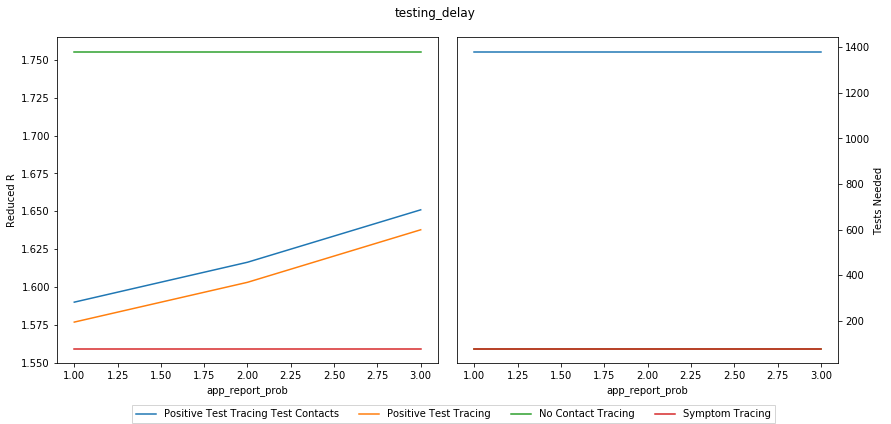

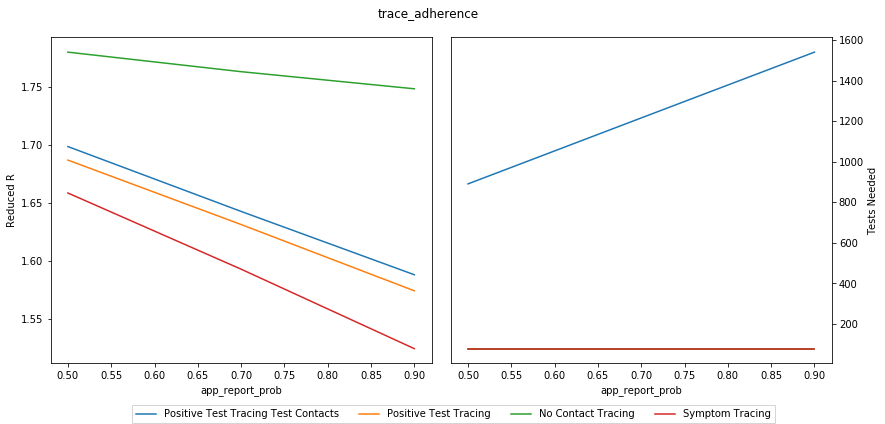

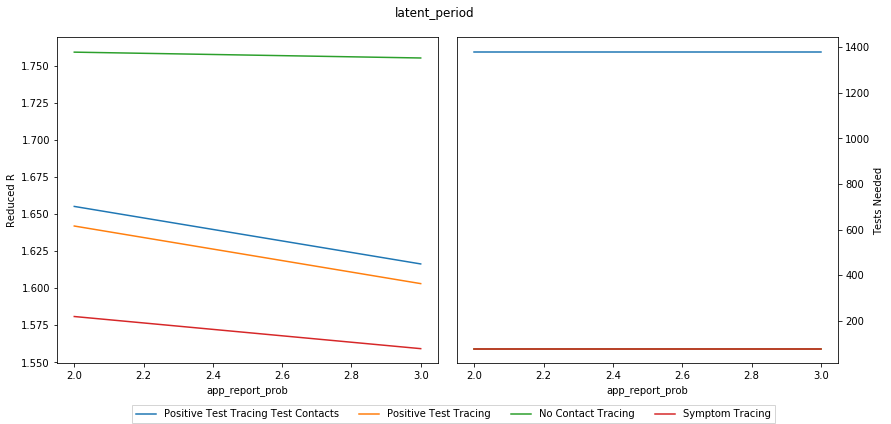

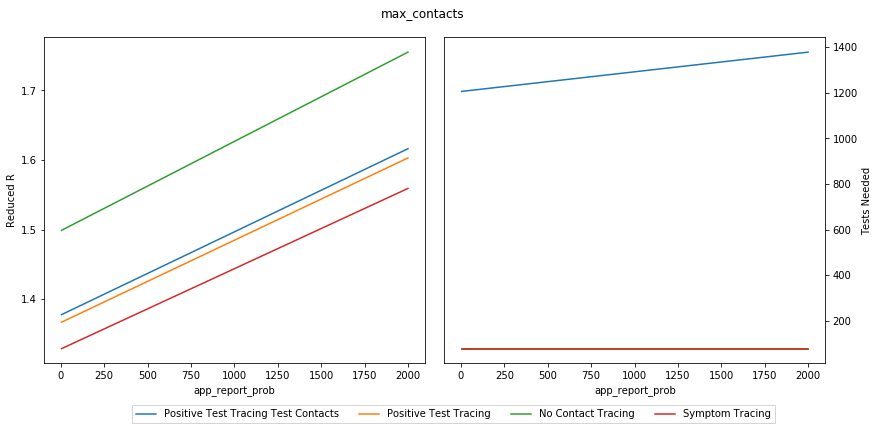

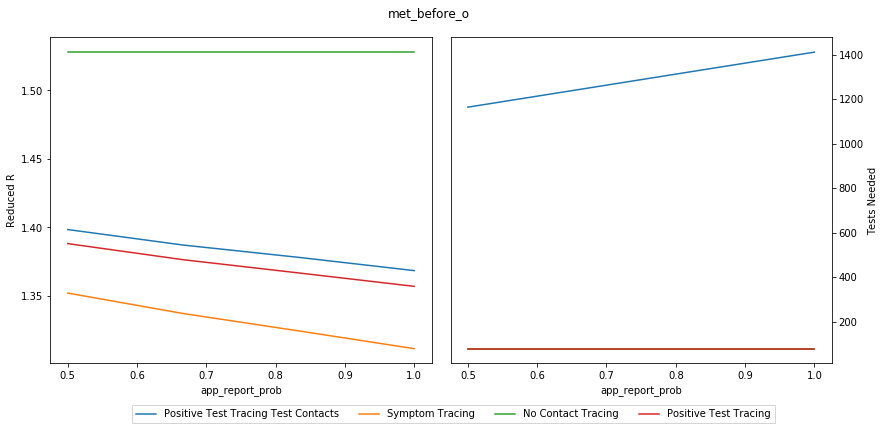

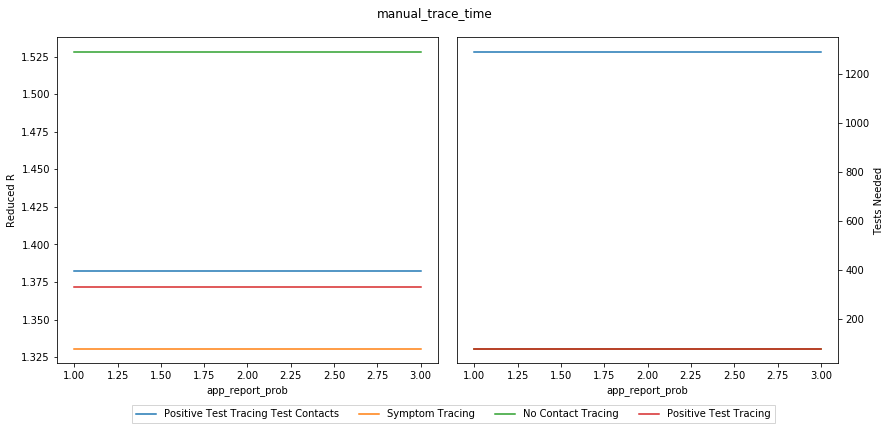

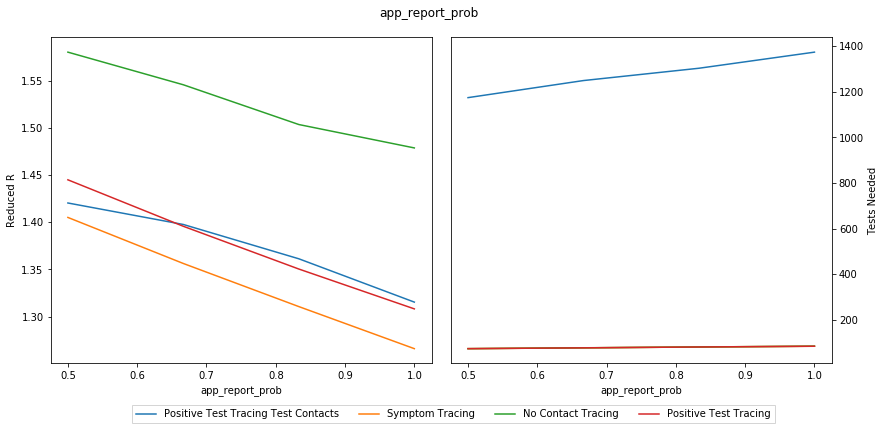

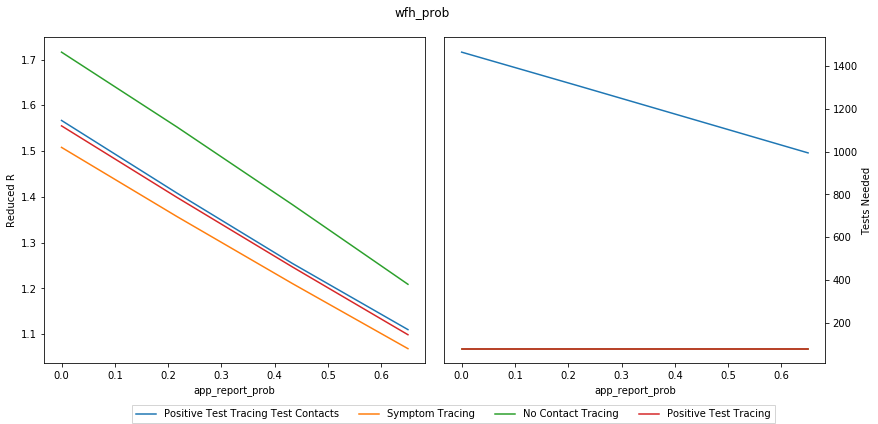

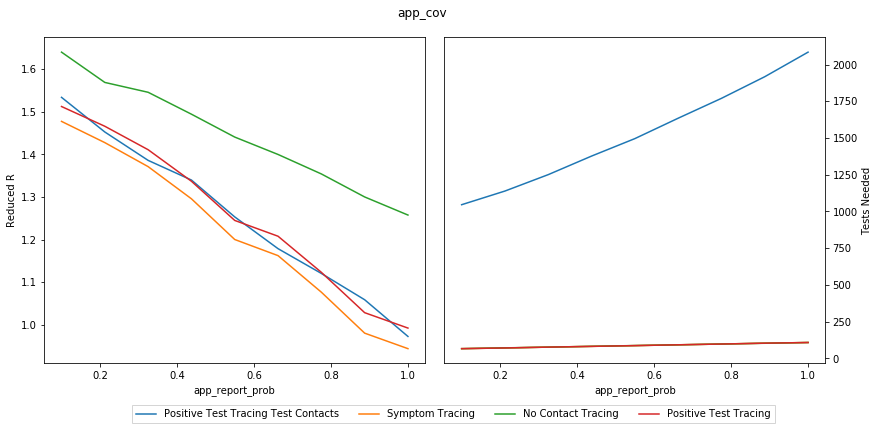

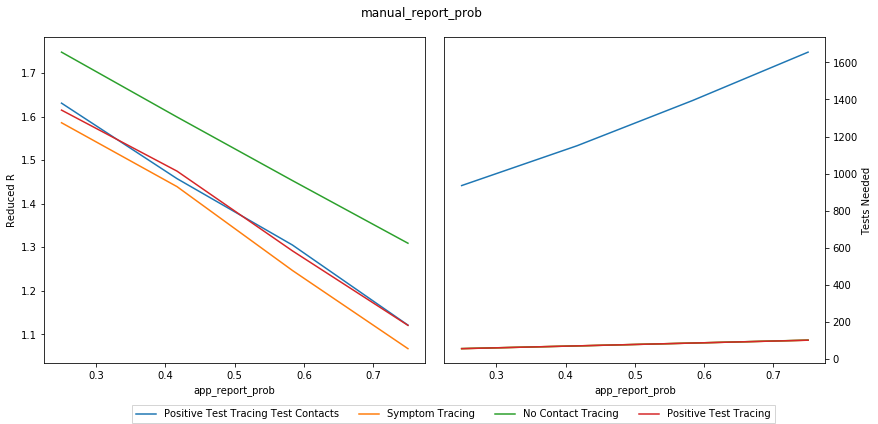

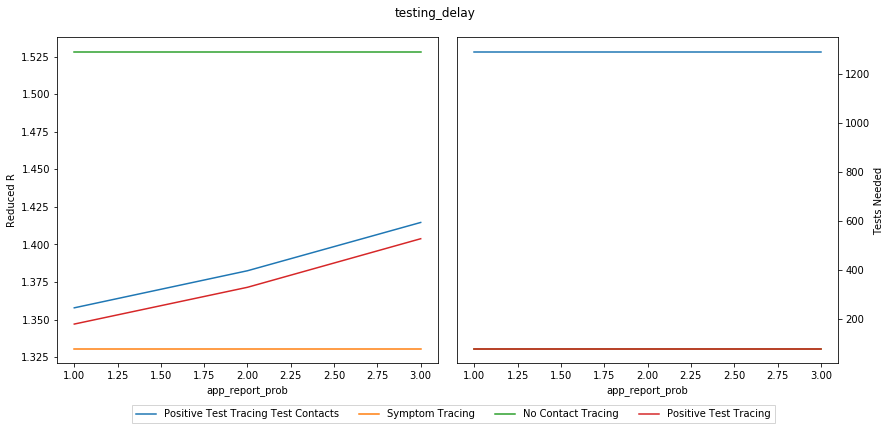

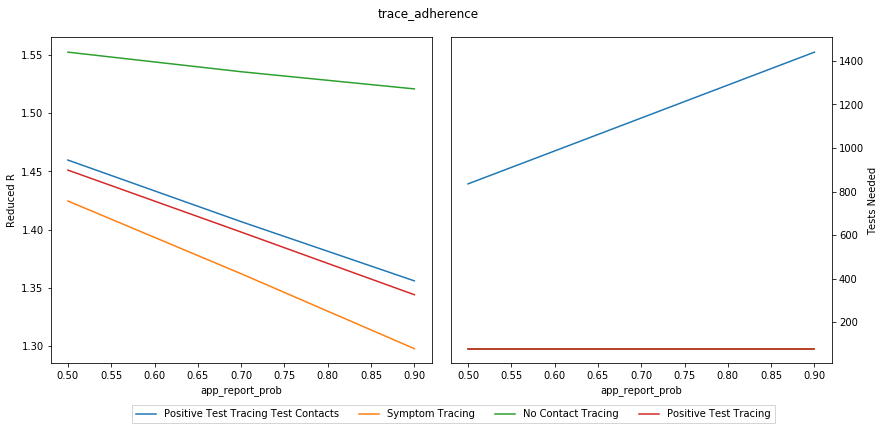

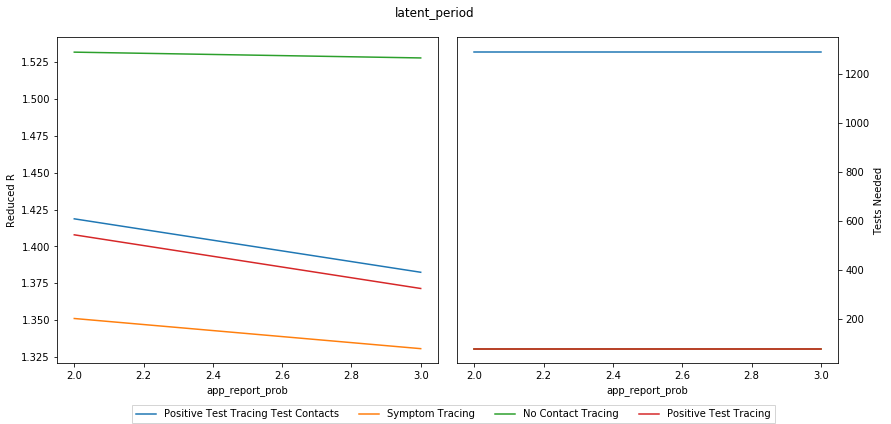

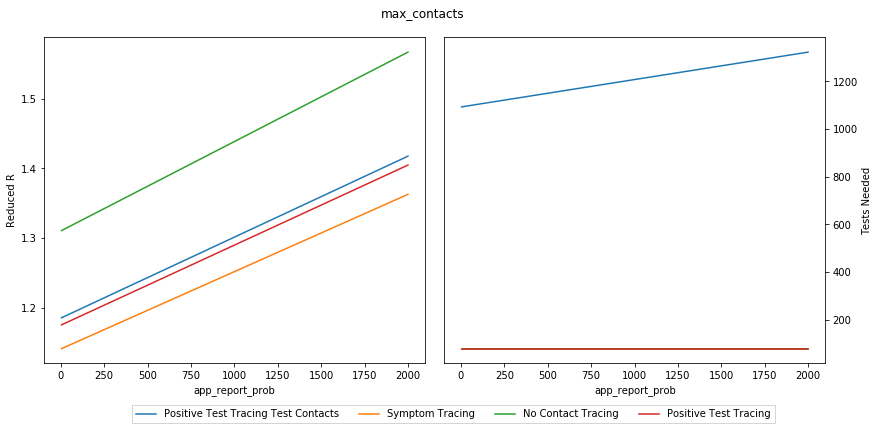

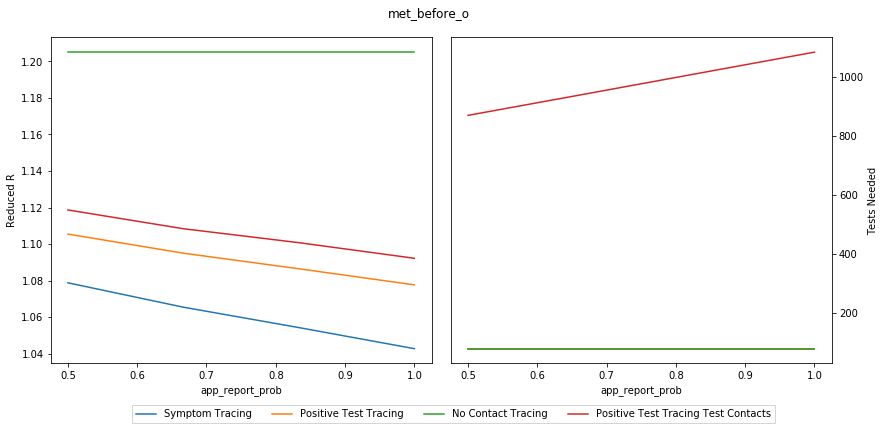

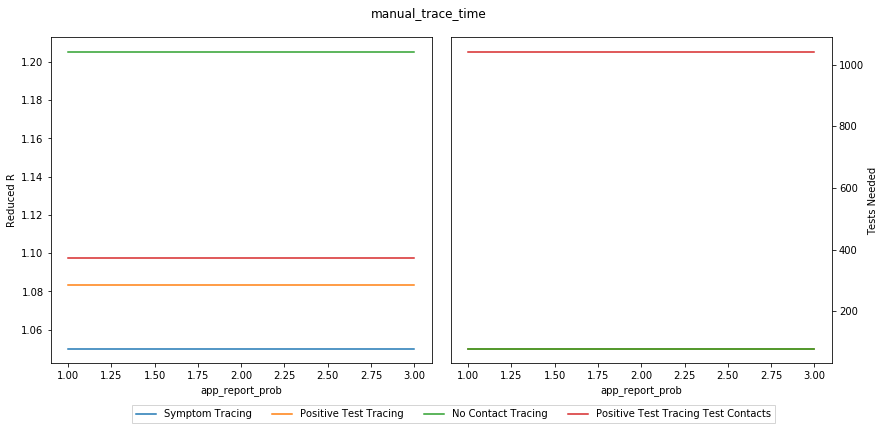

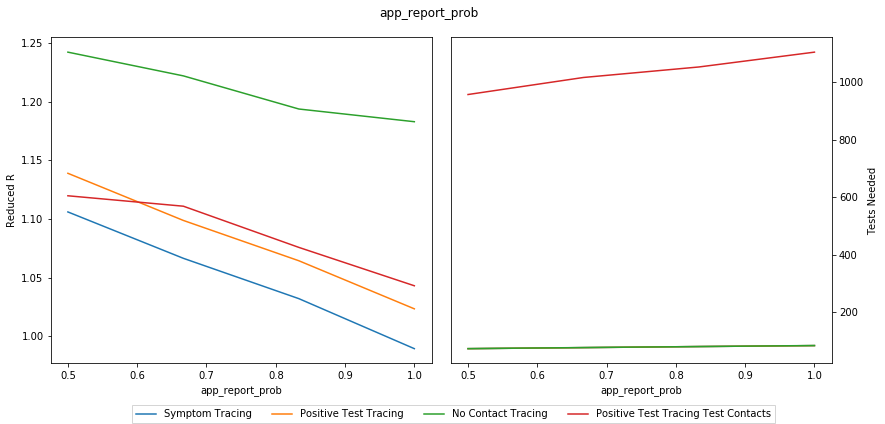

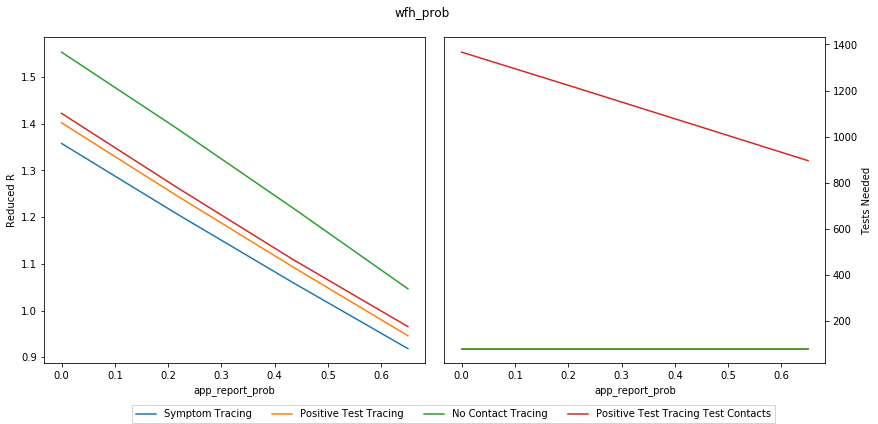

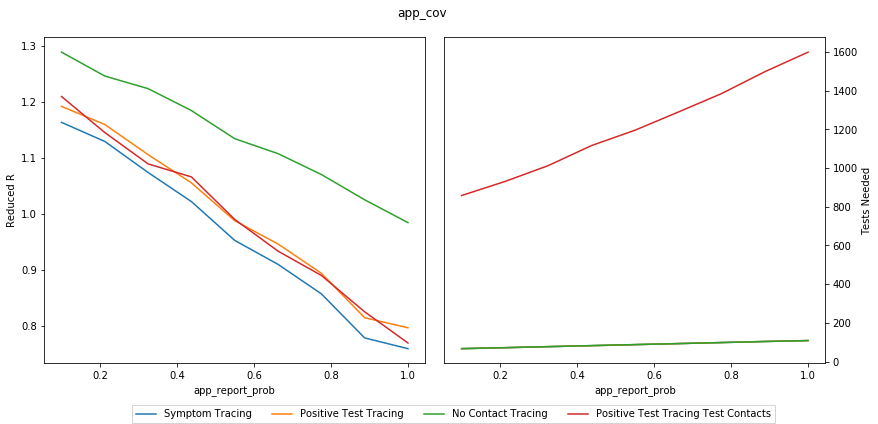

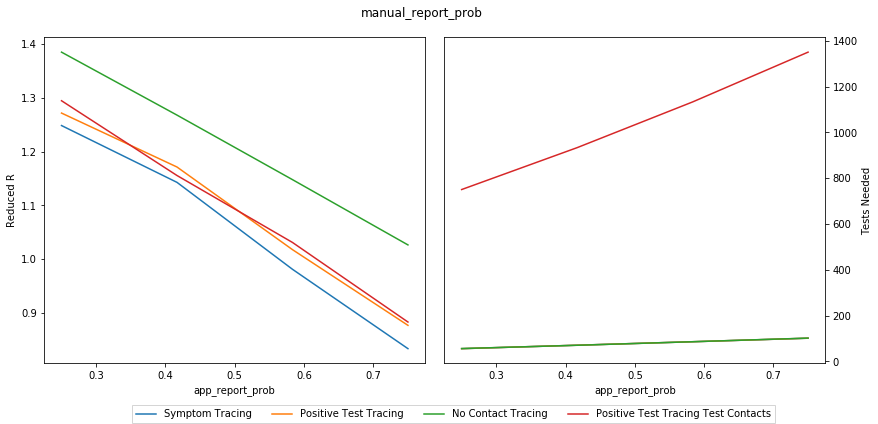

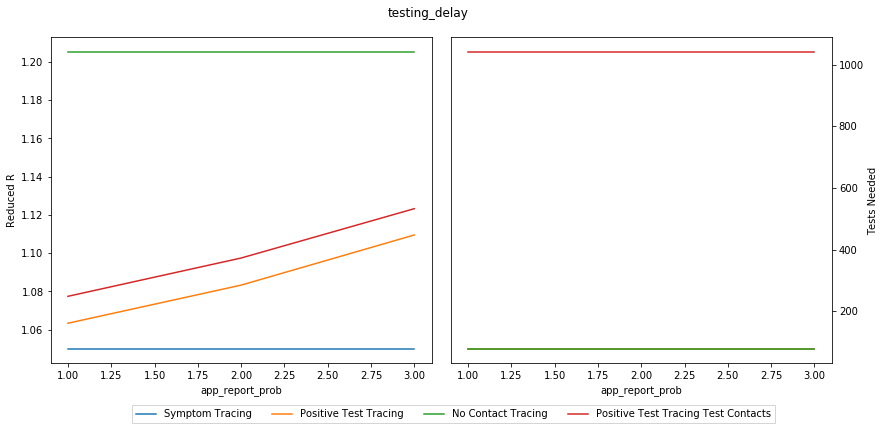

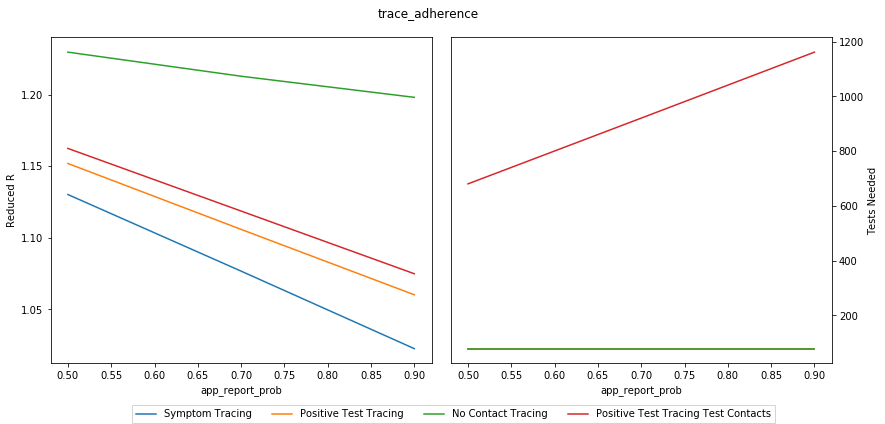

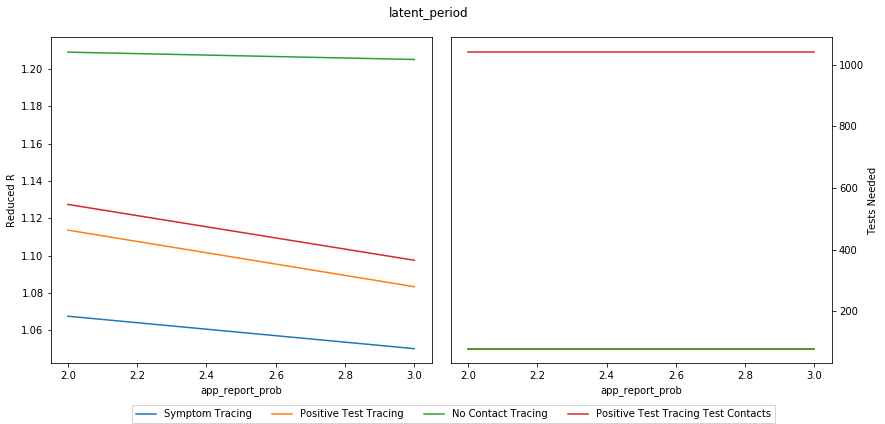

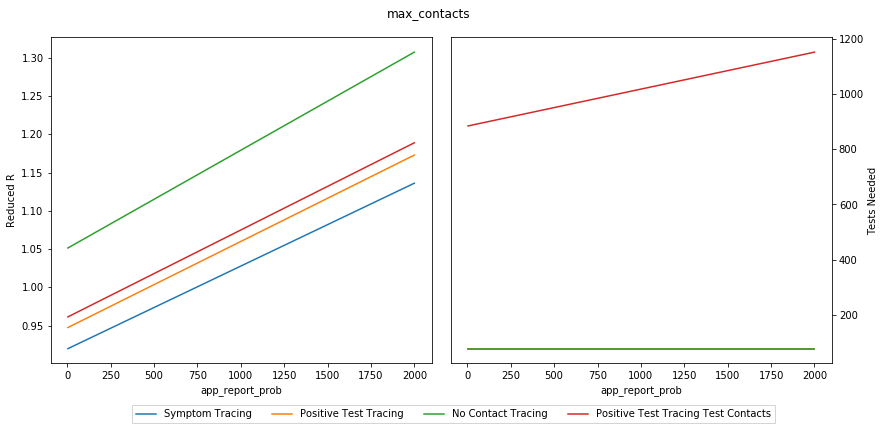

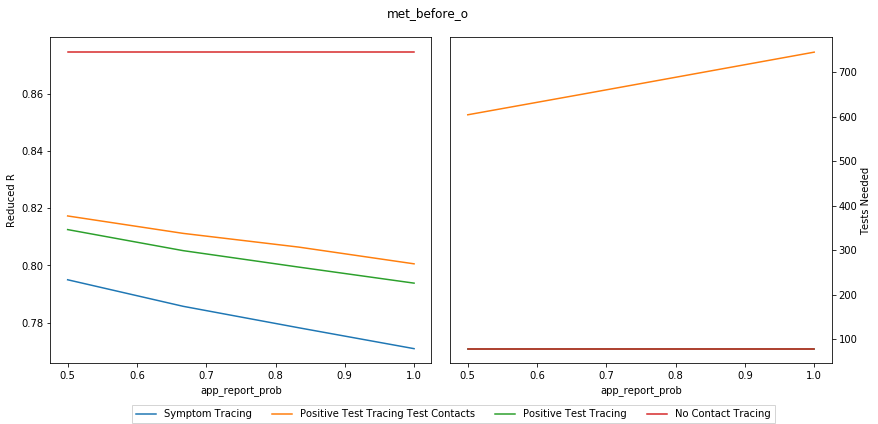

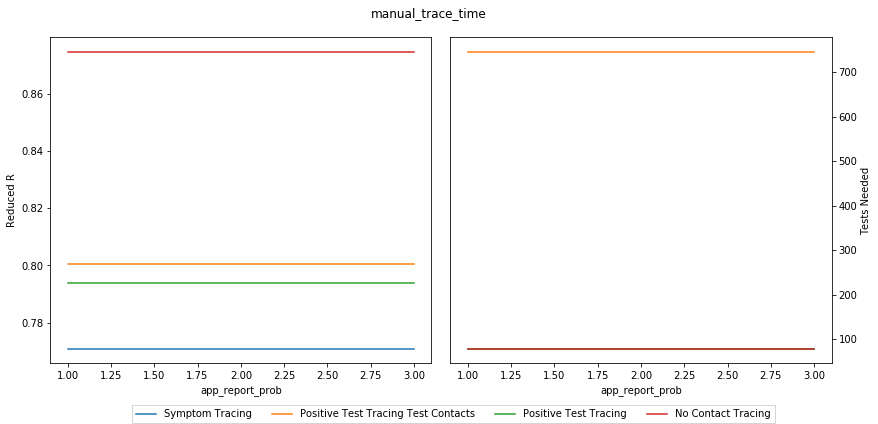

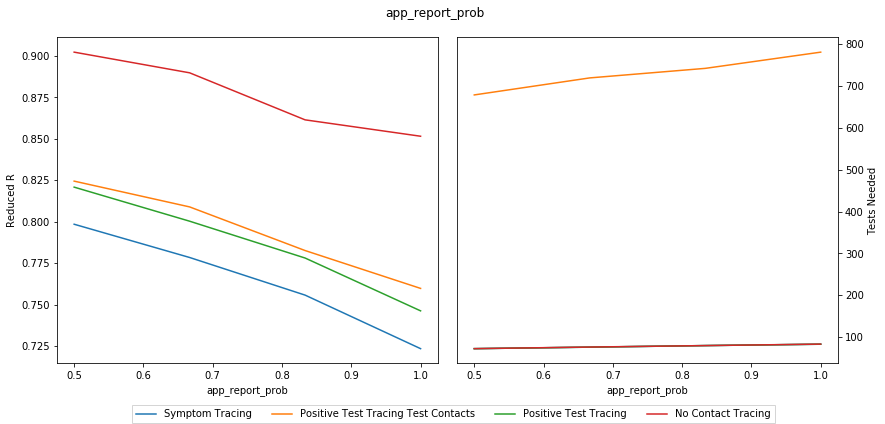

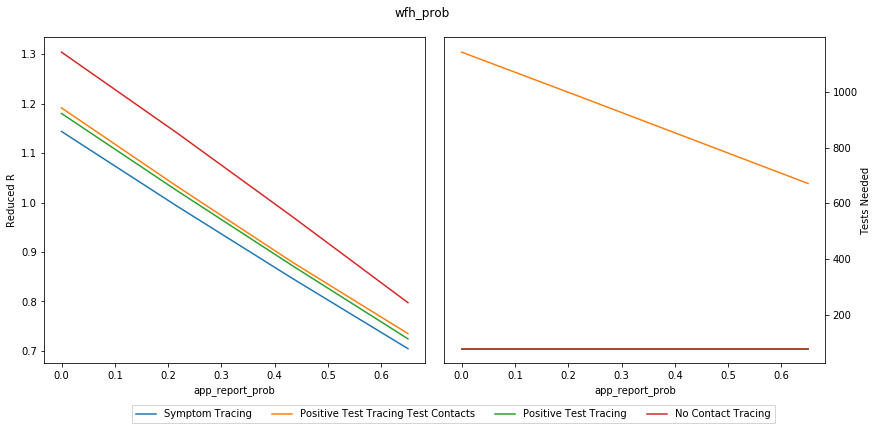

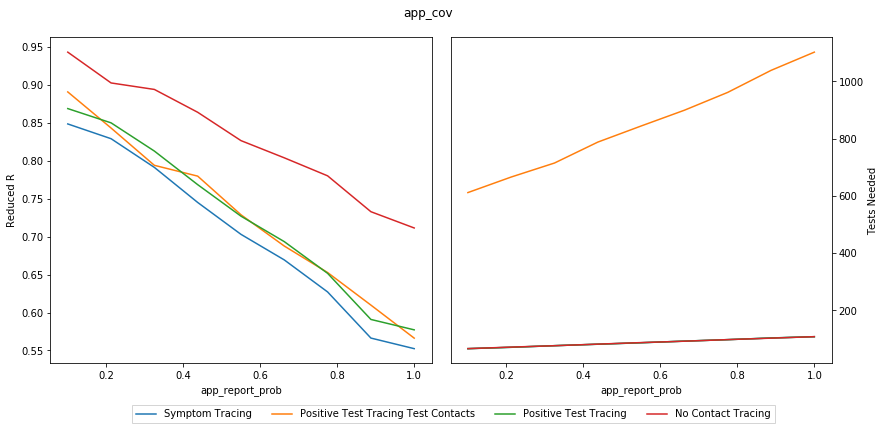

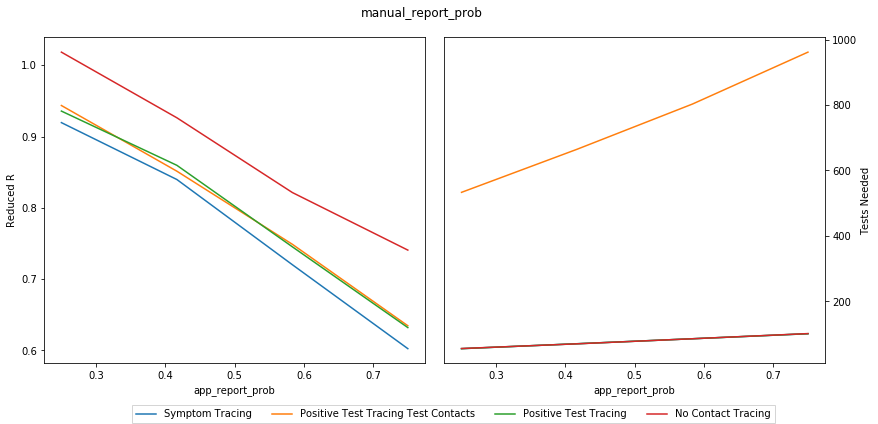

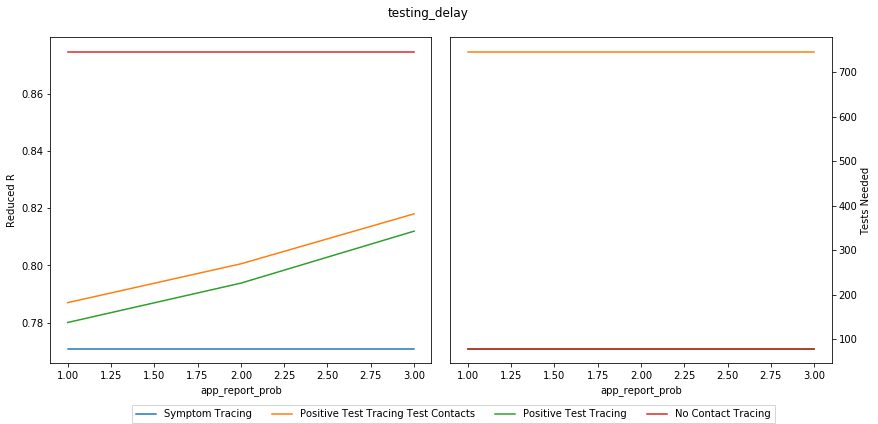

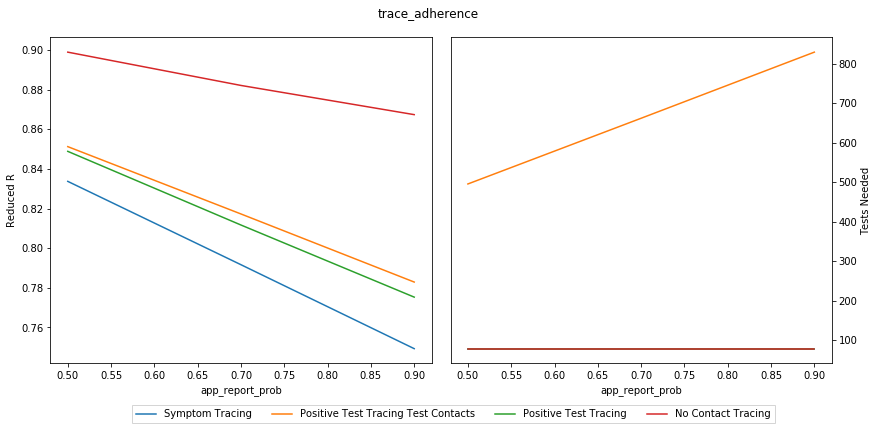

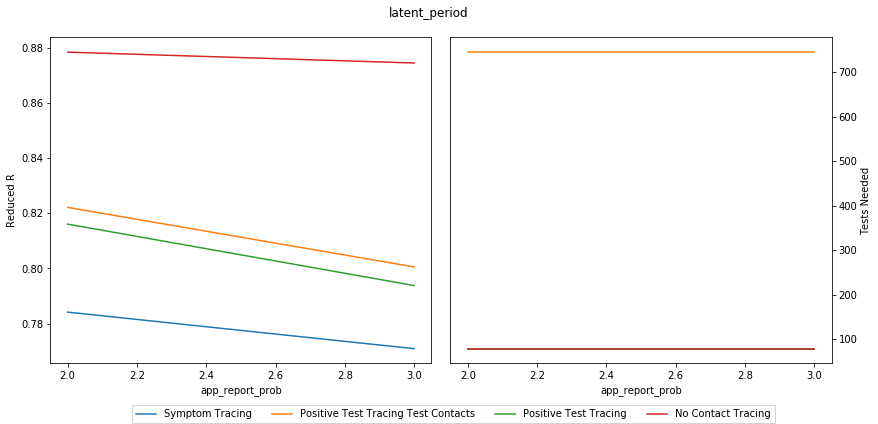

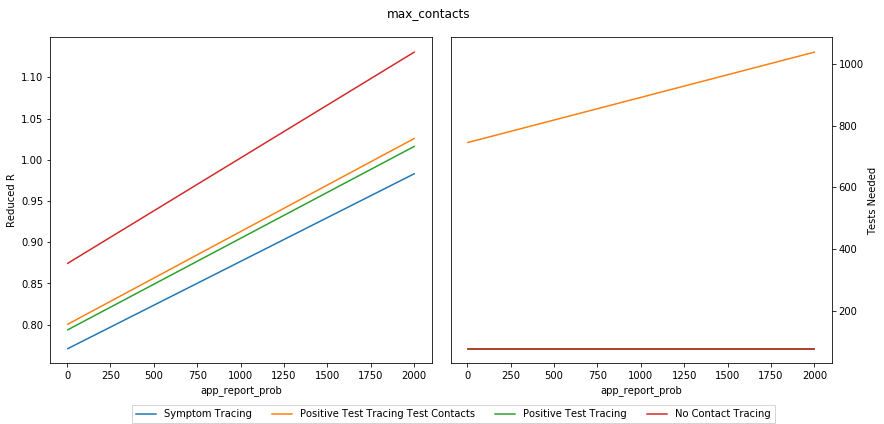

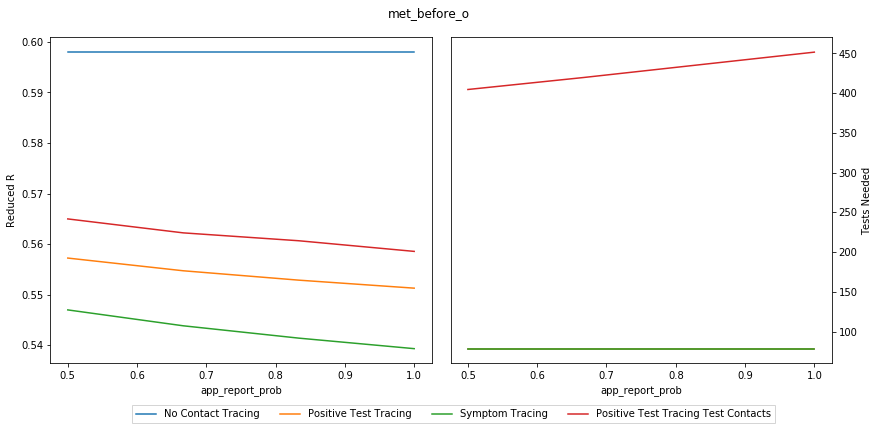

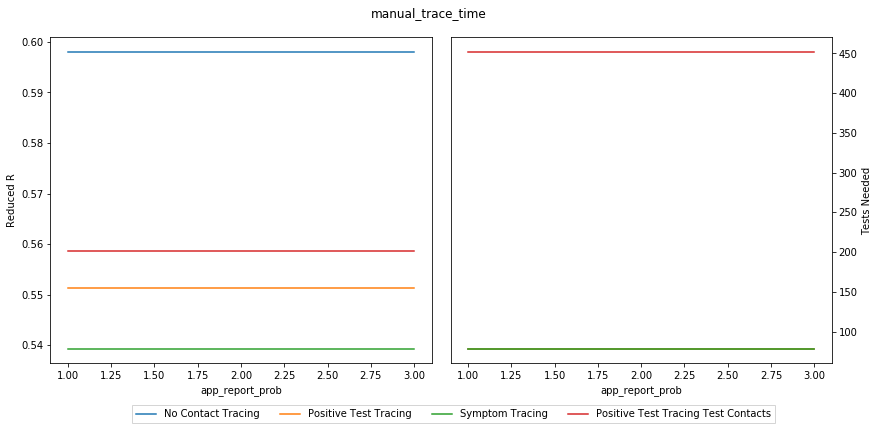

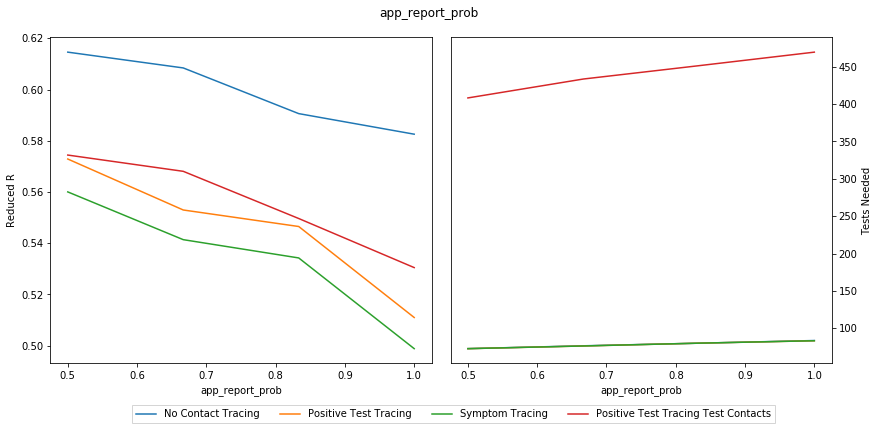

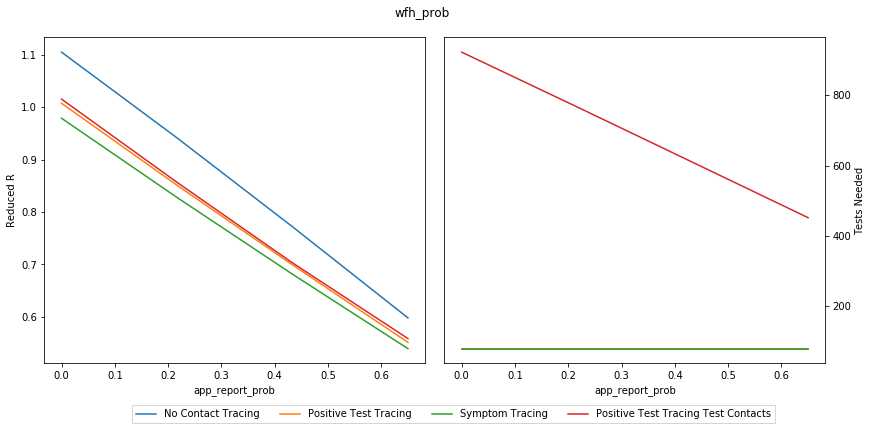

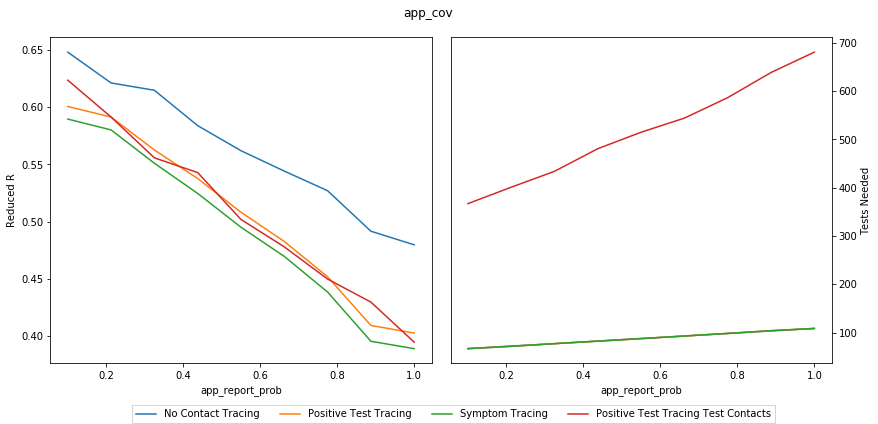

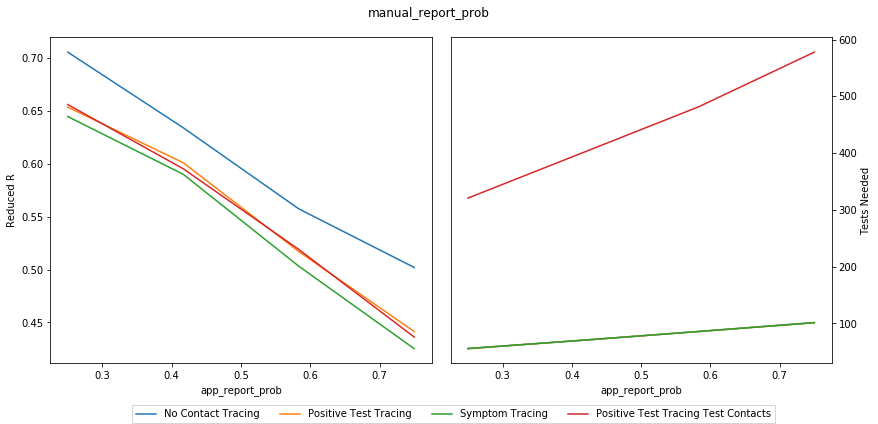

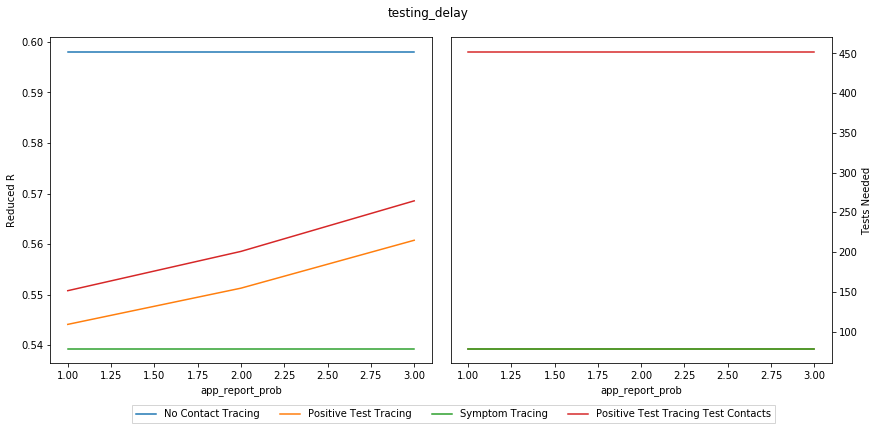

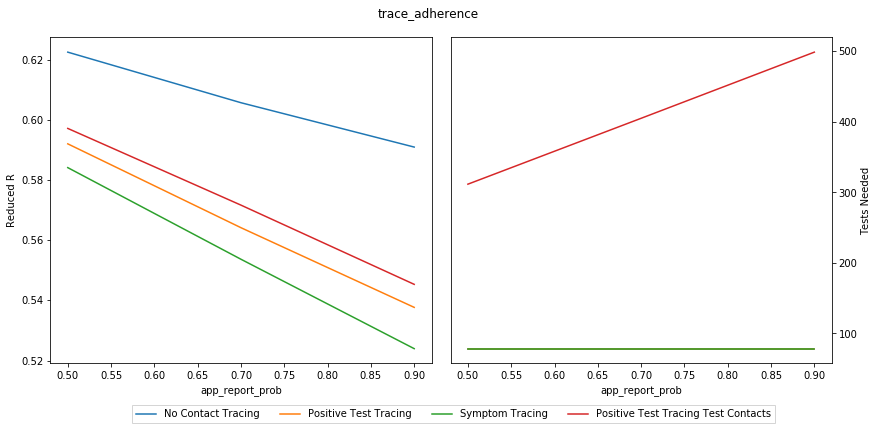

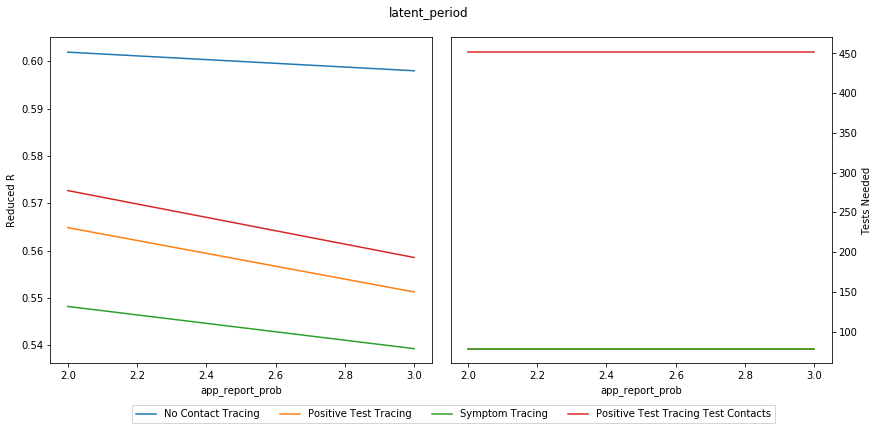

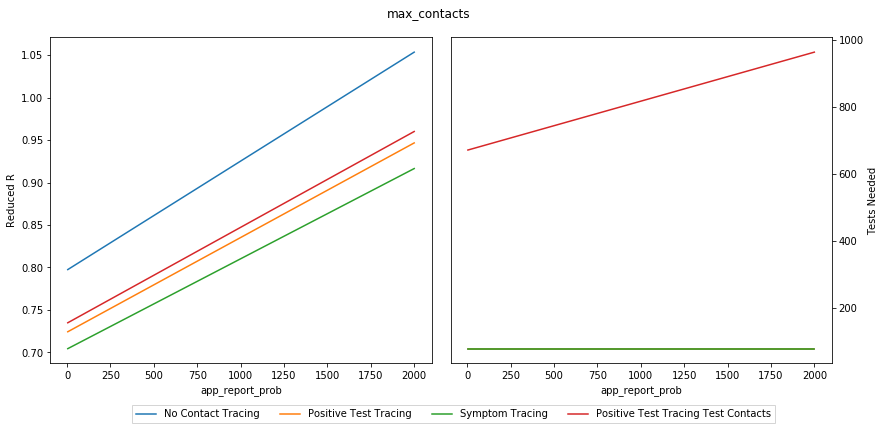

In [8]:
%%capture
with plt.rc_context(rc_dct):
    for level, results in lockdown_results.items():
        deck = utils.PdfDeck()
        plot_lockdown(results, deck, keys_to_plot)
        deck.make(os.path.join(output_folder, f"{level}_pinch_points.pdf"))

In [9]:
assert False

AssertionError: 

In [ ]:
lockdowns = [
     'L1_no_contact_tracing',
     'L1_positive_test_tracing',
     'L1_positive_test_tracing_test_contacts',
     'L1_symptom_tracing',
     'L2_no_contact_tracing',
     'L2_positive_test_tracing',
     'L2_positive_test_tracing_test_contacts',
     'L2_symptom_tracing',
     'L3_no_contact_tracing',
     'L3_positive_test_tracing',
     'L3_positive_test_tracing_test_contacts',
     'L3_symptom_tracing',
     'L4_no_contact_tracing',
     'L4_positive_test_tracing',
     'L4_positive_test_tracing_test_contacts',
     'L4_symptom_tracing',
     'L5_no_contact_tracing',
     'L5_positive_test_tracing',
     'L5_positive_test_tracing_test_contacts',
     'L5_symptom_tracing'
]

In [ ]:
plt.rcParams['figure.figsize'] = (13, 6)

lockdown_levels = range(1, 6)
n_lockdowns = len(next(iter(senstivity_results.values())))

for lockdown_name, lockdown_dct in lockdown_results.items():
    

    fig, axarr = plt.subplots(1, len(keys_to_plot), sharex=True)
    for name, ax in zip(keys_to_plot, axarr.flat):
        for lockdown_name, sim_results in lockdown_dct.items():
            if lockdown_name[1] != '5':
                continue
            xvals, reslist = zip(*sim_results)
            arg_order = np.argsort(xvals)
            xaxis = np.array(xvals)[arg_order]
            res = take_key(reslist, name)[arg_order]
            ax.plot(xaxis, res, label=nice_lockdown_name(lockdown_name))
            
        ax.set_ylabel(name)
        ax.set_xlabel(nice_param_name(target))
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    fig.legend(
        *ax.get_legend_handles_labels(),
        ncol=4,
        bbox_to_anchor=(0.45, -0.01),
        loc="lower center",
        fancybox=False,
    )
    fig.suptitle(nice_param_name(target), y=0.95)
    plt.subplots_adjust(wspace=0.05)


In [ ]:
xvals

In [ ]:
senstivity_results

In [ ]:
for target, lockdown_dct in sensitivity

In [ ]:
results

In [ ]:
cfg

In [ ]:
def get_param_data(param, scenarios, output_folder):
    config_count = len(glob.glob(f'{output_folder}/{scenarios[0]}/*.json'))
    
    df_list = []

    for scenario in scenarios:
        for i in range(config_count):
            config_path = f'{output_folder}/{scenario}/config_{i}.json'
            run_path = f'{output_folder}/{scenario}/run_{i}.csv'

            with open(config_path) as config_file:
                run_config = json.load(config_file)

            if run_config['sensitivity_target'] == param:
                df = pd.read_csv(run_path, index_col=None, header=0)
                df['Strategy'] = scenario
                df[param] = run_config['config'][param]
                df_list.append(df)

    return pd.concat(df_list, axis=0, ignore_index=True)



def plots_for_param(param, df, scenarios, param_label=None, plot_tests=True, save_as=None):
    if param_label is None:
        param_label = param


    colors = cm.rainbow(np.linspace(0, 1, len(scenarios)))
        
    fig = plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    for i, scenario in enumerate(scenarios):
        plt.plot(df[df['Strategy']==scenario][param], df[df['Strategy']==scenario]['Reduced R'], c=colors[i], label=scenario);
    plt.xlabel(param_label);
    plt.ylabel('R');
    plt.legend()

    plt.subplot(1, 2, 2)
    for i, scenario in enumerate(scenarios):
        plt.plot(df[df['Strategy']==scenario][param], df[df['Strategy']==scenario]['Tests Needed'], c=colors[i], label=scenario);
    plt.xlabel(param_label);
    plt.ylabel('Number of tests needed');
    plt.legend()
    
    plt.suptitle(f'Sensitivity to {param_label}')
    
    
    if save_as is not None:
        plt.savefig(save_as)

def table_for_param(param, df, param_label=None, as_latex=True):
    df = df[[param, 'Reduced R', 'Tests Needed']]
    
    if param_label is None:
        param_label = param
    
    df = df.rename(columns={param: param_label, 'Reduced R': 'R'})
    
    if as_latex:
        return df.to_latex()
    else:
        return df

# example usage
df = get_param_data("app_cov", ["L4", "L3"], "tmp_output")
plots_for_param("app_cov", df, param_label="App coverage", scenarios=["L4", "L3"], save_as=None)
table_for_param("app_cov", df, param_label="App coverage", as_latex=False)

In [ ]:
parameters = [
    {'name': 'testing_delay', 'label': 'Time needed to get test result',
     'show_plot': True, 'show_table': False,
     'plot_pareto': False, 'save_as': None},
    
    {'name': 'manual_trace_time', 'label': 'Time needed to trace contacts without an app',
     'show_plot': True, 'show_table': False,
     'plot_pareto': False, 'save_as': None},
    
    {'name': 'app_cov', 'label': 'App uptake',
     'show_plot': True, 'show_table': False,
     'plot_pareto': False, 'save_as': None},
    
    {'name': 'trace_adherence', 'label': 'Policy adherence to quarantine on being traced as a contact',
     'show_plot': True, 'show_table': False,
     'plot_pareto': False, 'save_as': None},
    
    {'name': 'app_report_prob', 'label': 'Probability of reporting symptoms via app',
     'show_plot': True, 'show_table': False,
     'plot_pareto': False, 'save_as': None},
    
    {'name': 'manual_report_prob', 'label': 'Probability of reporting symptoms without app',
     'show_plot': True, 'show_table': False,
     'plot_pareto': False, 'save_as': None},
    
    {'name': 'latent_period', 'label': 'Period from getting infected to being infectious',
     'show_plot': True, 'show_table': False,
     'plot_pareto': False, 'save_as': None},
    
    {'name': 'met_before_o', 'label': 'Probability the case person met contacts in Other before',
     'show_plot': True, 'show_table': False,
     'plot_pareto': False, 'save_as': None},
    
    {'name': 'max_contacts', 'label': 'Max contacts a person can have a day',
     'show_plot': True, 'show_table': False,
     'plot_pareto': False, 'save_as': None},
    
    {'name': 'wfh_prob', 'label': 'WFH probability',
     'show_plot': True, 'show_table': False,
     'plot_pareto': False, 'save_as': None},
]

In [ ]:
scenarios_to_plot = all_scenarios

for param in parameters:
    df = get_param_data(param['name'], scenarios_to_plot, output_folder)
    if param['show_plot']:
        plots_for_param(param['name'], df, param_label=param['label'], scenarios=scenarios_to_plot,
                        save_as=param['save_as'])

    if param['show_table']:
        print(table_for_param(param['name'], df, param_label=param['label'], as_latex=param['as_latex']))